### Required activity 25.3: Portfolio project on optimising a model for real-life data

This project will be built with aim of predicting stock prices using Long Short Term Memory (LSTM). 

### Part 1. Finding a dataset

1. What format is the data in? Dates and numeric

2. Is the data clean? Yes, data downloaded from Yahoo! are cleaned.

3. How large is the dataset? Sizable data since 1980.

4. How will you split your data into train, validate and test sets? 60%, 20%, 20%

In [1]:
# Testing
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

now = datetime.now().date()
start = now - timedelta(days=90)

For simplicity sake, we will be using just Tesla stock.

In [2]:
# 1. Fetch Historical Stock Prices
data = yf.download('TSLA')#, start=start)
data = data[['Close']]

[*********************100%%**********************]  1 of 1 completed


### Part 2. Exploratory Data Analysis (EDA)
1. Explore, clean and pre-process 
2. Dimension reduction & feature engineering

In [3]:
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

nasdaq_price = nasdaq.history(period=None)
sp500_price = sp500.history(period=None)

nasdaq_price = nasdaq_price.iloc[-len(data):,:]
sp500_price = sp500_price.iloc[-len(data):,:]
data.tail()

,Close
Date,
2023-10-09,259.670013
2023-10-10,263.619995
2023-10-11,262.989990
2023-10-12,258.869995
2023-10-13,251.119995


In [4]:
print(f'Total records are {data.shape[0]}. \nNull check \n{data.isnull().count()}')

Total records are 3347. 
Null check 
Close    3347
dtype: int64


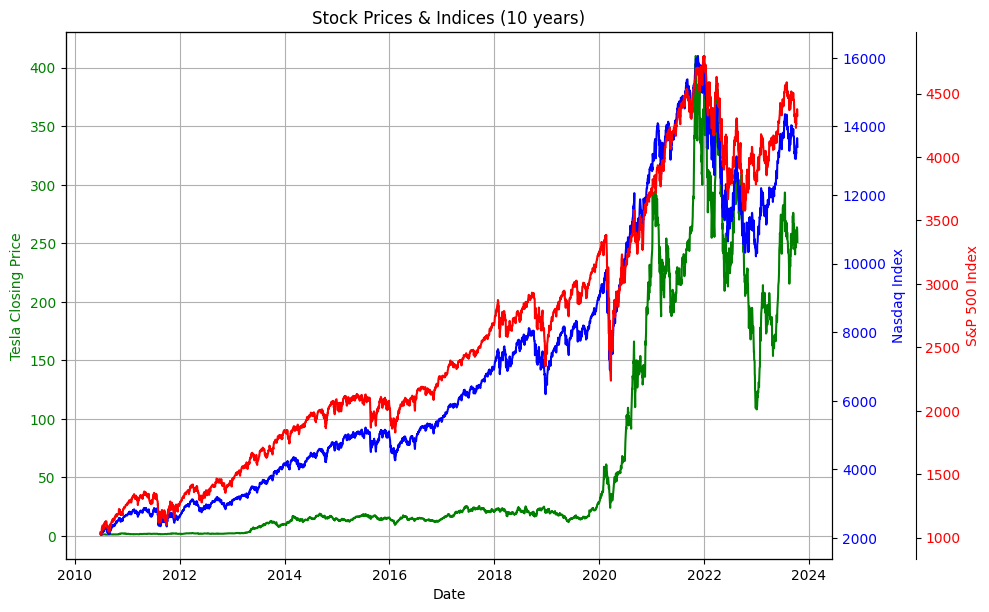

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(data['Close'], label='Tesla Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices & Indices (10 years)')
plt.show()

Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [6]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data = data.copy()
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data.loc[:, 'MACD'] = short_ema - long_ema
    # Signal Line
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

data = compute_macd(data)
data.head()

,Close,MACD,Signal_Line
Date,,,
2010-06-29,1.592667,0.000000,0.000000
2010-06-30,1.588667,-0.000319,-0.000064
2010-07-01,1.464000,-0.010510,-0.002153
2010-07-02,1.280000,-0.033053,-0.008333
2010-07-06,1.074000,-0.066772,-0.020021


In [7]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI'] = compute_rsi(data['Close'], 14)
data.head() # Notice the first 13 rows RSI are NaN due to calculation window

,Close,MACD,Signal_Line,RSI
Date,,,,
2010-06-29,1.592667,0.000000,0.000000,NaN
2010-06-30,1.588667,-0.000319,-0.000064,NaN
2010-07-01,1.464000,-0.010510,-0.002153,NaN
2010-07-02,1.280000,-0.033053,-0.008333,NaN
2010-07-06,1.074000,-0.066772,-0.020021,NaN


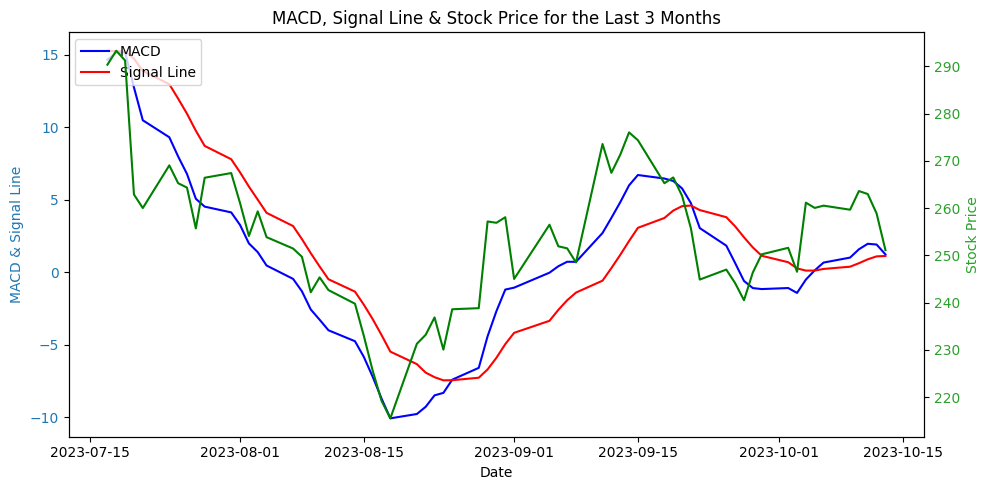

In [8]:
# 3 months period plot
# Plotting MACD and stock price
end_date = data.index[-1]  # Get the last date
start_date = end_date - timedelta(days=90)  # approx. 3 months

filtered_data = data[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='blue')
ax1.plot(filtered_data.index, filtered_data['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('MACD, Signal Line & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

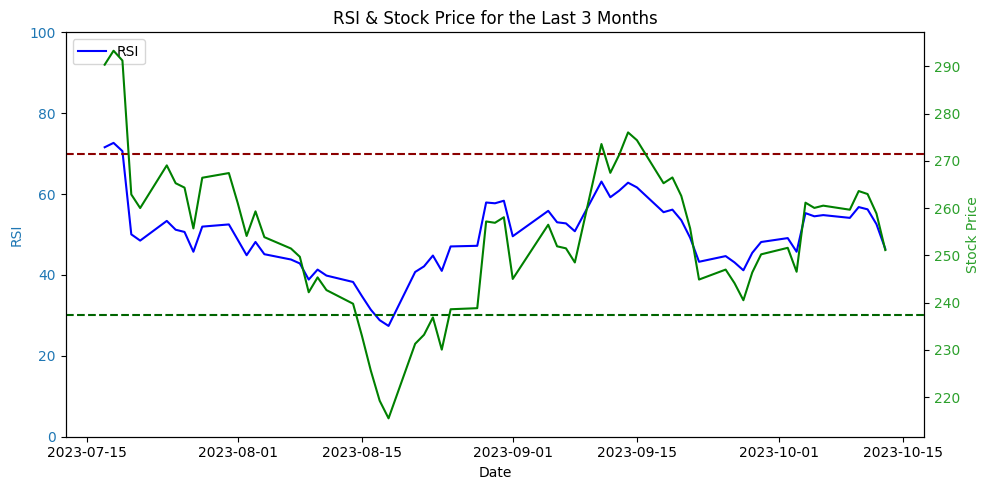

In [9]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('RSI & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [10]:
print(f'Total records are {data.shape[0]}. \nNull check \n{data.isnull().sum()}')

Total records are 3347. 
Null check 
Close           0
MACD            0
Signal_Line     0
RSI            13
dtype: int64


In [11]:
correlation_matrix = data.corr()
correlation_matrix

,Close,MACD,Signal_Line,RSI
Close,1.000000,0.206521,0.218023,0.038684
MACD,0.206521,1.000000,0.952542,0.492525
Signal_Line,0.218023,0.952542,1.000000,0.400581
RSI,0.038684,0.492525,0.400581,1.000000


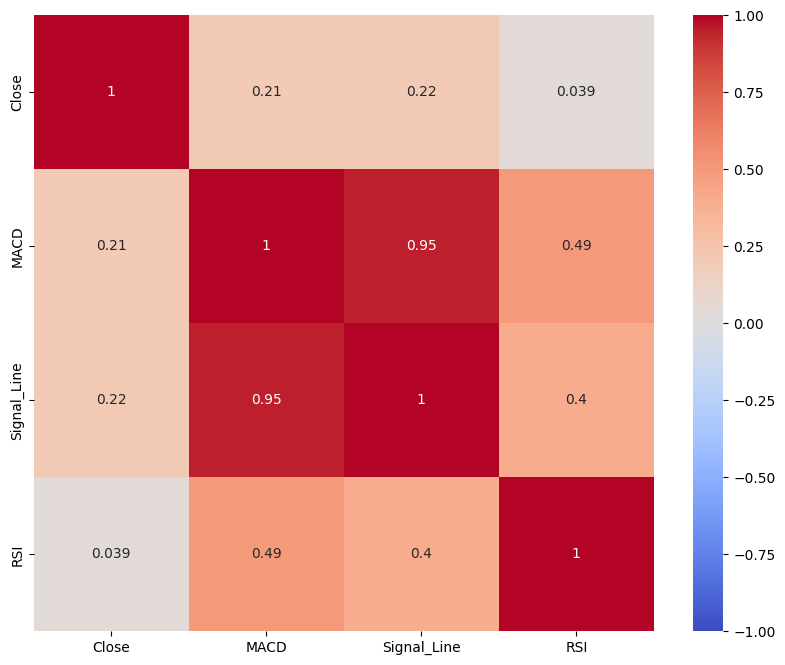

In [12]:
# Using Seaborn to plot a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

We can note from the seaborn plot that MACD, Signal Line and RSI are all good features to be used to predict 'Close' price. For a simple approach, we will be using just the 'Closing' price for LSTM. 

### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 80%
2. Test: Last 5 days will be used for testing.
3. Validation: Takes the rest

Project is a regression problem, hence we will be testing out performance metrics.
1. Mean Square Error (MSE)

In [13]:
data = data[['Close']]

In [14]:
# 2. Preprocess the Data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#.values.reshape(-1, 1))

# Convert data to PyTorch tensors and create in/out sequence data
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 5
inout_seq = create_inout_sequences(data_normalized, train_window)
inout_seq = [(torch.FloatTensor(seq), torch.FloatTensor(label)) for seq, label in inout_seq]

# Split data into train, validate, and test sets
total_length = len(inout_seq)
test_length = 5
remaining_length = total_length - test_length

train_length = int(0.9 * remaining_length)
valid_length = remaining_length - train_length

train_dataset = inout_seq[:train_length]
valid_dataset = inout_seq[train_length:train_length+valid_length]
test_dataset = inout_seq[-test_length:]

Epoch 0/30 - Training loss: 0.0038, Validation loss: 0.0588
Epoch 10/30 - Training loss: 0.0084, Validation loss: 0.0651
Epoch 20/30 - Training loss: 0.0055, Validation loss: 0.0582


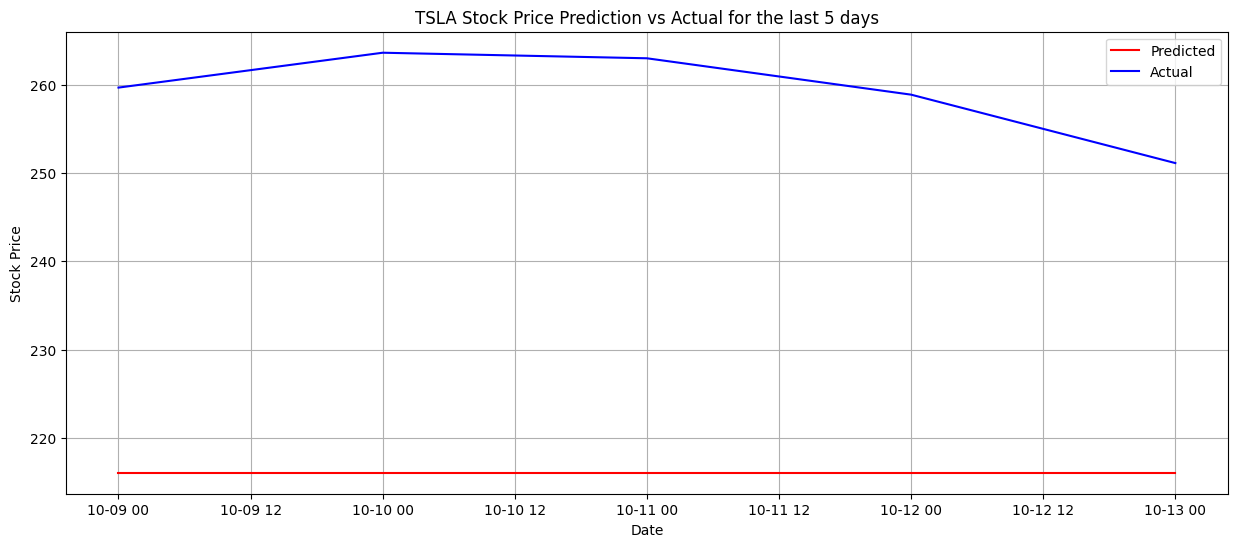

[[216.04593732]
 [216.04593732]
 [216.04593732]
 [216.04593732]
 [216.04593732]]


In [15]:
# 3. Build LSTM Model - Pytorch
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    
    
def main(train_window, train_dataset, valid_dataset, test_dataset, bo) :
    input_dim = 1
    hidden_dim = int(bo[0])
    num_layers = int(bo[1])
    output_dim = 1

    dropout = float(bo[2]) #0.01
    learning_rate = float(bo[3]) #0.01
    epochs = int(bo[4])
    
    model = LSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for seq, labels in train_dataset:
            optimizer.zero_grad()
            y_pred = model(seq.view(1, train_window, -1))
            loss = criterion(y_pred, labels)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        valid_losses = []
        for seq, labels in valid_dataset:
            with torch.no_grad():
                y_pred = model(seq.view(1, train_window, -1))
                loss = criterion(y_pred, labels)
                valid_losses.append(loss.item())
        avg_valid_loss = np.mean(valid_losses)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Training loss: {avg_train_loss:.4f}, Validation loss: {avg_valid_loss:.4f}')

    # Testing for the last 5 days
    test_inputs = data_normalized[-test_length:].tolist()
    model.eval()
    for _ in range(test_length):  # Predicting for next 5 days
        seq = torch.FloatTensor(test_inputs[-train_window:]).view(1, train_window, -1)
        with torch.no_grad():
            test_inputs.append([model(seq).item()])

    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
    dates = data.index[-test_length:]
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_predictions, label='Predicted', color='red')
    plt.plot(dates, scaler.inverse_transform(data_normalized[-5:]), label='Actual', color='blue')
    plt.title("TSLA Stock Price Prediction vs Actual for the last 5 days")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return(actual_predictions)
    
if __name__ == '__main__':
    bo = [64, 2, 0.3, 0.01, 30]     # hidden_dim, num_layers, dropout, learning_rate, epoch
    actual_predictions = main(train_window, train_dataset, valid_dataset, test_dataset, bo) 
    print(actual_predictions)

In [16]:
actual_predictions, data.tail(len(actual_predictions))
abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
print(f'Sum of 5 windows differents from predicted with actual : {abs_different.values}')

Sum of 5 windows differents from predicted with actual : [216.04030241]


### Part 3. Hyperparameter Optimization

From the plot above, we can observe that the prediction is pretty bad. Options is to try to tune the parameters to see if plots can get closer to the actual test. 

From the high validation loss, we can conclude that the the model is overfitting.

Bayesian Optimization

In [17]:
from statistics import NormalDist
from scipy.stats import norm
from sklearn.decomposition import KernelPCA, PCA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF 

In [18]:
X = np.array(bo)
Y = np.array(abs_different) # val_loss # Validation loss
X = X.reshape(1, -1)  
Y = Y.reshape(-1, 1)  
print(X.shape,Y.shape)
X,Y

(1, 5) (1, 1)


(array([[6.4e+01, 2.0e+00, 3.0e-01, 1.0e-02, 3.0e+01]]),
 array([[216.04030241]]))

A combination of 3 acquistion functions and picking the highest values for the nexy query point. The aim of this BO is to seek a global minima

In [19]:
#PI
def probability_improvement(eta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.0001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    best_observed = np.min(df_y) #.max(df_y) 
    
    pi = []
    for k in range(len(query_points)):
        pi.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(best_observed - eta))
        
    pi = np.array(pi)
    next_query_point = query_points[np.argmin(pi)] #[np.argmax(pi)]
    
    return query_points, pi 

#UCB
def upper_confidence_bound(beta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    ucb = mean - (beta * std)
    
    next_query_point = query_points[np.argmin(ucb)] # [np.argmax(ucb)]
    
    return query_points, ucb 

#EI
def expected_improvement(xi): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.0001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr,query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T
    
    f_best = np.min(df_y)
    mean, std = bogp.predict(query_points, return_std=True)
    
    z = (f_best - mean - xi) / std #    z = (mean - f_best - xi) / std
    ei = (f_best - mean - xi) * norm.cdf(z) - std * norm.pdf(z)# ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0  # Set EI to 0 where std is 0 to avoid division by zero.

    next_query_point = query_points[np.argmax(ei)] # This is correct

    return query_points, ei 

In [20]:
# stack new query and observation for every loop
def update_surrogate_model(new_X, new_y):
    if len(X) == 0 and len(Y) == 0:
        # If X and Y are empty, just return the new_X and new_y
        return new_X, new_y

    # Stack them vertically
    df_X = np.vstack([X, new_X])
    df_y = np.vstack([Y, new_y])
    return df_X, df_y

# Picking the highest acquisition function value among UCB, EI and PI.
def choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi):
    
    # Find the index of the element with the highest acquisition function value for each method
    min_ucb_index = np.argmin(af_ucb)
    min_pi_index = np.argmin(af_pi)
    max_ei_index = np.argmax(af_ei)

    # Get the corresponding query points with the highest acquisition function values
    next_query_point_min_ucb = next_query_point_ucb[min_ucb_index]
    next_query_point_max_ei = next_query_point_ei[max_ei_index]
    next_query_point_min_pi = next_query_point_pi[min_pi_index]


    # Compare the acquisition function values and choose the highest
    if af_ucb[min_ucb_index] <= af_ei[max_ei_index] and af_ucb[min_ucb_index] <= af_pi[min_pi_index]:
        return next_query_point_min_ucb, 'UCB'
    
    elif af_ei[max_ei_index] >= af_ucb[min_ucb_index] and af_ei[max_ei_index] >= af_pi[min_pi_index]:
        return next_query_point_max_ei, 'Expected Improvement'
    
    else:
        return next_query_point_min_pi, 'Probability of Improvement'


Next suggested query point by UCB: 64, 2, 0.2, 0.001, 40
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]] [[216.04030241]]
Epoch 0/40 - Training loss: 0.0090, Validation loss: 0.1067
Epoch 10/40 - Training loss: 0.0135, Validation loss: 0.1457
Epoch 20/40 - Training loss: 0.0060, Validation loss: 0.0083
Epoch 30/40 - Training loss: 0.0024, Validation loss: 0.0085


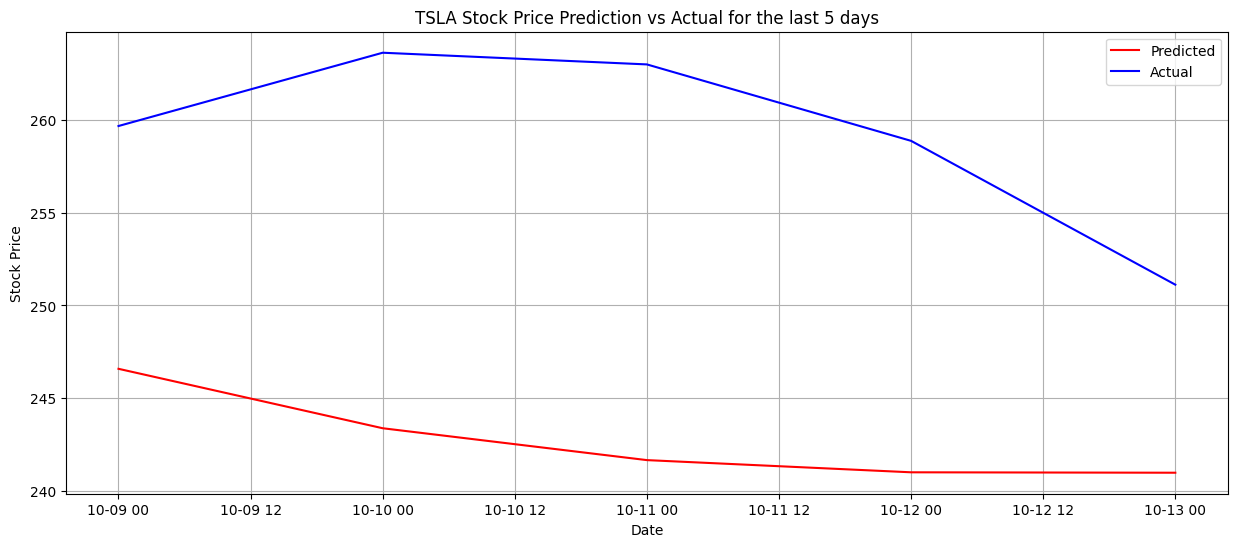

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]], with loss of [82.63843492]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 50
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]] [[216.04030241]
 [ 82.63843492]]
Epoch 0/50 - Training loss: 0.0092, Validation loss: 0.1039
Epoch 10/50 - Training loss: 0.0050, Validation loss: 0.0678
Epoch 20/50 - Training loss: 0.0131, Validation loss: 0.0856
Epoch 30/50 - Training loss: 0.0031, Validation loss: 0.0134
Epoch 40/50 - Training loss: 0.0019, Validation loss: 0.0091


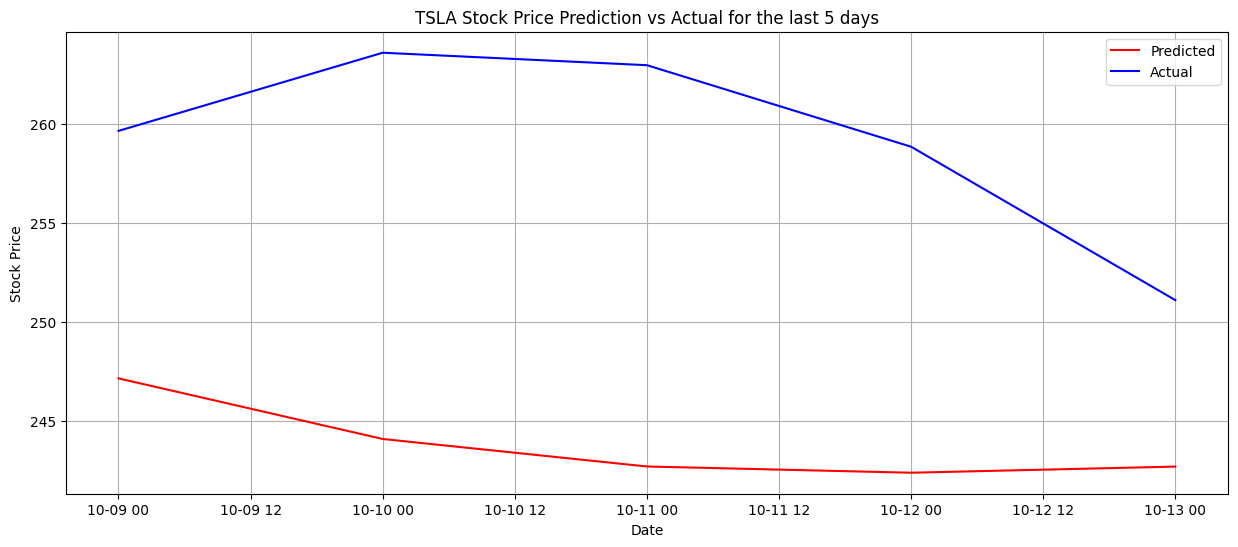

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 5.0e+01]], with loss of [77.18148335]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 60
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 5.0e+01]] [[216.04030241]
 [ 82.63843492]
 [ 77.18148335]]
Epoch 0/60 - Training loss: 0.0089, Validation loss: 0.1032


In [ ]:
query = np.empty((0, len(X[0])))  # Assuming X is a 2D array
obs = np.empty((0, 1))  # 1D column vector

noise_assumption = 1e-10
rbf_lengthscale = 0.1
beta = 1.96        # UCB exploration parameter. beta increases, exploration increases.
eta = 0.1         # PI exploration parameter. 0.1 for explore, 0.01 for exploitiation
xi = 0.1          # EI exploration parameter. 0.1  for balance, 0.01 for exploitiation

# Fit the Gaussian Process Regression model
kernel = RBF(length_scale=rbf_lengthscale*len(X.T))
bogp = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=5)

breakcount = 0

while breakcount < 20 :
    if breakcount == 10:
        beta = 1
        eta = 0.01
        xi = 0.01
        
    # Update the surrogate model with the new observation
    df_X, df_y = update_surrogate_model(query, obs)
    X = df_X
    Y = df_y
    
    # Fit the surrogate model with the given dataset
    bogp.fit(df_X, df_y)

    # # Get the next suggested query point
    next_query_point_ucb, af_ucb = upper_confidence_bound(beta)
    next_query_point_pi, af_pi = probability_improvement(eta)
    next_query_point_ei, af_ei = expected_improvement(xi)

    # # Comparing 3 aq. function and choose the highest.
    next_query_point, chosen_af = choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi)

    print(f'Next suggested query point by {chosen_af}: '
          f'{np.round(next_query_point[0], 0):.0f}, '
          f'{np.round(next_query_point[1], 0):.0f}, '
          f'{np.round(next_query_point[2], 1):.1f}, '
          f'{np.round(next_query_point[3], 3):.3f}, '
          f'{np.round(next_query_point[4], 0):.0f}')
    print(df_X, df_y)
    bo = next_query_point #For bo hidden_dim, num_layers, dropout, learning_rate, epoch

    actual_predictions = main(train_window, train_dataset, valid_dataset, test_dataset, bo) 
    abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
    query = np.array(bo).reshape(1, -1)
    obs = np.array(abs_different) # val_loss # Validation loss
    
    print(f'BO is {query}, with loss of {obs}')
    
    breakcount +=1
    if abs_different.iloc[-1] < 5:
        break


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_y, marker='o', linestyle='-', color='b')
plt.title('Pytorch BO visualisation')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

From the results obtained from 50 queries, It is noted that.

1. The most similar trend between predicted and actual are from bo = [288, 2, 0.2, 0.001, 80]. 

2. The lowest different are from bo = [64.   2.   0.2  0.1 30. ]. However, the predicted lines are almost a straight line instead of following the trend. 

We do not want the lowest score as a straight line doesn't provide any information of where the trend is heading to. Instead, we should opt for option 1. 

Lets try TensorFlow instead of python. Fixing a layer of 2.

### TensorFlow LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


train_window = 5
inout_seq = create_inout_sequences(data_normalized, train_window)
total_length = len(inout_seq)

train_length = int(0.8 * (total_length-5))
valid_length = total_length - 5 - train_length

train_dataset = inout_seq[:train_length]
valid_dataset = inout_seq[train_length:train_length+valid_length]
test_dataset = inout_seq[-5:]

train_x = np.array([item[0] for item in train_dataset])
train_y = np.array([item[1] for item in train_dataset])
valid_x = np.array([item[0] for item in valid_dataset])
valid_y = np.array([item[1] for item in valid_dataset])

class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{self.params["epochs"]} - Training loss: {logs["loss"]:.4f}, Validation loss: {logs["val_loss"]:.4f}')
                
                
def main_tf(train_x, train_y, valid_x, valid_y, test_dataset, bo):
    
    hidden_dim = int(bo[0])
    dropout = float(bo[1]) #0.01
    learning_rate = float(bo[2])
    epoch = int(bo[3])
    
    model = Sequential()
    model.add(LSTM(hidden_dim, activation='relu', input_shape=(train_window, 1), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(hidden_dim, activation='relu', return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    history = model.fit(train_x, train_y, epochs=epoch, 
                        validation_data=(valid_x, valid_y), verbose=1, callbacks=[PrintLossCallback()])

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    test_x = np.array([item[0] for item in test_dataset])
    test_y = np.array([item[1] for item in test_dataset])

    predictions = model.predict(test_x)
    actual_predictions = scaler.inverse_transform(predictions)
    dates = data.index[-5:]

    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_predictions, label='Predicted', color='red')
    plt.plot(dates, scaler.inverse_transform(test_y.reshape(-1, 1)), label='Actual', color='blue')
    plt.title("TSLA Stock Price Prediction vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return(actual_predictions)
    
if __name__ == '__main__':

    bo = [64, 0.3, 0.01, 300]     # hidden_dim, dropout, learning rate, epoch
    actual_predictions = main_tf(train_x, train_y, valid_x, valid_y, test_dataset, bo) 
    print(actual_predictions)

In [ ]:
X = np.array(bo)
Y = np.array(abs_different) # val_loss # Validation loss
X = X.reshape(1, -1)  
Y = Y.reshape(-1, 1)  
print(X.shape,Y.shape)
X,Y

In [ ]:
#PI
def probability_improvement(eta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.001, 0.1, 4)    
    query_range_epoch = np.linspace(100, 100, 8)
    
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_dropout, 
                       query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    best_observed = np.min(df_y) #.max(df_y) 
    
    pi = []
    for k in range(len(query_points)):
        pi.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(best_observed - eta))
        
    pi = np.array(pi)
    next_query_point = query_points[np.argmin(pi)] #[np.argmax(pi)]
    
    return query_points, pi 

#UCB
def upper_confidence_bound(beta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.001, 0.1, 4)    
    query_range_epoch = np.linspace(100, 100, 8)
    
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_dropout, 
                       query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    ucb = mean - (beta * std)
    
    next_query_point = query_points[np.argmin(ucb)] # [np.argmax(ucb)]
    
    return query_points, ucb 

#EI
def expected_improvement(xi): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.001, 0.1, 4)    
    query_range_epoch = np.linspace(100, 100, 8)
    
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_dropout, 
                       query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T
    
    f_best = np.min(df_y)
    mean, std = bogp.predict(query_points, return_std=True)
    
    z = (f_best - mean - xi) / std #    z = (mean - f_best - xi) / std
    ei = (f_best - mean - xi) * norm.cdf(z) - std * norm.pdf(z)# ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0  # Set EI to 0 where std is 0 to avoid division by zero.

    next_query_point = query_points[np.argmax(ei)] # This is correct

    return query_points, ei 

In [ ]:
query = np.empty((0, len(X[0])))  # Assuming X is a 2D array
obs = np.empty((0, 1))  # 1D column vector

noise_assumption = 1e-10
rbf_lengthscale = 0.1
beta = 1.96        # UCB exploration parameter. beta increases, exploration increases.
eta = 0.1         # PI exploration parameter. 0.1 for explore, 0.01 for exploitiation
xi = 0.1          # EI exploration parameter. 0.1  for balance, 0.01 for exploitiation

# Fit the Gaussian Process Regression model
kernel = RBF(length_scale=rbf_lengthscale*len(X.T))
bogp = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=5)

breakcount = 0

while breakcount < 20 :
    if breakcount == 10:
        beta = 1
        eta = 0.01
        xi = 0.01
        
    # Update the surrogate model with the new observation
    df_X, df_y = update_surrogate_model(query, obs)
    X = df_X
    Y = df_y
    
    # Fit the surrogate model with the given dataset
    bogp.fit(df_X, df_y)

    # # Get the next suggested query point
    next_query_point_ucb, af_ucb = upper_confidence_bound(beta)
    next_query_point_pi, af_pi = probability_improvement(eta)
    next_query_point_ei, af_ei = expected_improvement(xi)

    # # Comparing 3 aq. function and choose the highest.
    next_query_point, chosen_af = choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi)

    print(f'Next suggested query point by {chosen_af}: '
          f'{np.round(next_query_point[0], 0):.0f}, '
          f'{np.round(next_query_point[1], 0):.0f}, '
          f'{np.round(next_query_point[2], 3):.3f}, '
          f'{np.round(next_query_point[3], 0):.0f}')

    print(df_X, df_y)
    bo = next_query_point #For bo hidden_dim, learning_rate, epoch

    actual_predictions = main_tf(train_x, train_y, valid_x, valid_y, test_dataset, bo)
    abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
    query = np.array(bo).reshape(1, -1)
    obs = np.array(abs_different) # val_loss # Validation loss
    
    print(f'BO is {query}, with loss of {obs}')
    
    breakcount +=1
    if abs_different.iloc[-1] < 5:
        break


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_y, marker='o', linestyle='-', color='b')
plt.title('TensorFlow BO visualisation')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

# Conclusion

One question comes to mind when predicting stock market. Is stock price a causation or consequence? 

This project doesn't consider...
1. Transaction cost
2. Slippage
3. 